In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import time

In [3]:
start = time.time()
# Example: load a DSS dataset as a Pandas dataframe
hf_MODEL_JOINED_DATASET = dataiku.Dataset("DS_AI_INNOV_ENTRESTO_SWITCH_MODEL_MODEL_115VAR")
df_orig = hf_MODEL_JOINED_DATASET.get_dataframe()
# Creating a copy of the data
df = df_orig.copy()
df.shape
print(np.round(( time.time() - start)/60,2)," min")

0.09  min


In [4]:
df.TARGET = np.where ( df.TARGET == 0 , 0, 1 )
df.TARGET.value_counts()

1    28023
0    12583
Name: TARGET, dtype: int64

In [5]:
from tensorflow.keras.layers import Dense, Dropout #define layers
import os
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd

from RL_agent import TrainDDQN # RL training agents

In [6]:
episodes = 100000  # Total number of episodes
warmup_steps = 170000  #120,000 # Amount of warmup steps to collect data with random policy
memory_length = warmup_steps  # Max length of the Replay Memory
batch_size = 32 #64 
collect_steps_per_episode = 2000
collect_every = 500

target_update_period = 800  # Period to overwrite the target Q-network with the default Q-network
target_update_tau = 1  # Soften the target model update
n_step_update = 1

layers = [Dense(256, activation="relu"), Dropout(0.2),
          Dense(256, activation="relu"), Dropout(0.2),
          Dense(2, activation=None)]  # No activation, pure Q-values

learning_rate = 0.00025  # Learning rate
gamma = 0.7   # Discount factor #0.0 means only cares about rewards in the immediate state\
#gamma = 0.1
min_epsilon = 0.5  # Minimal and final chance of choosing random action
decay_episodes = episodes // 10  # Number of episodes to decay from 1.0 to `min_epsilon``

min_class = [0]  # Minority classes
maj_class = [1]  # Majority classes

In [7]:
df.train_valid_test.value_counts()

train    32410
test      4190
valid     4006
Name: train_valid_test, dtype: int64

In [8]:
# Defining the target & usable variables
Y = 'TARGET'
COL_NAMES_START = [ i for i in df.columns if i not in ["CHF_category", "APPROX_AGE_CAT" , "APPROX_AGE_GEN_CAT", "ind","train_valid_test","PERFED_DATE","PERFED_YYYY_MM","PATIENT_GENDER", "PERFED_DT", "PATIENT_BIRTH_YEAR", "LVEF_CATEGORY", "PATIENT_ID_SYNTH", "VALUE_GENERATED", "TARGET","CHF_4YR_FLAG"]]
# "CHF_PRE_2YR_FLAG"
len(COL_NAMES_START)

101

In [9]:
df_new = df.copy()

In [10]:
#COLS_NAMES = COL_NAMES_START_100
COLS_NAMES = COL_NAMES_START
X_train = df_new[df_new.train_valid_test == 'train'][COLS_NAMES]
y_train = df_new[df_new.train_valid_test == 'train'][Y]

X_valid = df_new[df_new.train_valid_test == 'valid'][COLS_NAMES]
y_valid = df_new[df_new.train_valid_test == 'valid'][Y]

X_test = df_new[df_new.train_valid_test == 'test'][COLS_NAMES]
y_test = df_new[df_new.train_valid_test == 'test'][Y]

X_train.shape , y_train.shape , X_valid.shape , y_valid.shape , X_test.shape , y_test.shape

((32410, 101), (32410,), (4006, 101), (4006,), (4190, 101), (4190,))

In [11]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()
X_val = X_valid.to_numpy()
y_val = y_valid.to_numpy()

In [12]:
model = TrainDDQN(episodes, warmup_steps, learning_rate, gamma, min_epsilon, decay_episodes,    
                  target_update_period=target_update_period, target_update_tau=target_update_tau,
                  batch_size=batch_size, collect_steps_per_episode=collect_steps_per_episode,
                  memory_length=memory_length, collect_every=collect_every, 
                  n_step_update=n_step_update)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  26112     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  65792     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  514       
Total params: 92,418
Trainable params: 92,418
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results

Training the DDQN:   0%|          | 500/100000 [00:02<07:39, 216.42it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Training the DDQN: 100%|██████████| 100000/100000 [10:11<00:00, 163.43it/s]


Best score: 0.864786!


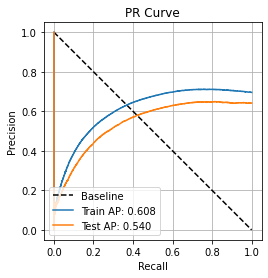

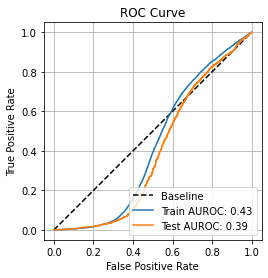

Best score: 0.864786!
Best score: 0.864786!
{'F1': 0.8472012102874433, 'Precision': 0.8608762490392006, 'Recall': 0.8339538346984363, 'TP': 2240, 'TN': 1142, 'FP': 362, 'FN': 446}
[1 0 0 ... 1 0 1]
[[-0.23257002  2.036101  ]
 [ 1.8891175   0.47531426]
 [ 2.275647    0.5859295 ]
 ...
 [-0.912815    2.5017874 ]
 [ 1.7830437   0.43887374]
 [-0.099296    1.7662487 ]]


In [13]:
model.fit(X_train, y_train, layers)
model.q_net.summary() #print out the training layers information
model.train(X_val, y_val, "Precision")

stats = model.evaluate(X_test, y_test, X_train, y_train)
y_pred = model.predict(X_test) 
y_pred_q = model.predict_proba(X_test) # Q value and not probabilty
print(stats)
print(y_pred)
print(y_pred_q)

In [16]:
print(stats)

{'F1': 0.8472012102874433, 'Precision': 0.8608762490392006, 'Recall': 0.8339538346984363, 'TP': 2240, 'TN': 1142, 'FP': 362, 'FN': 446}
